### Identification of changes in structural parameters with single point 6C observations

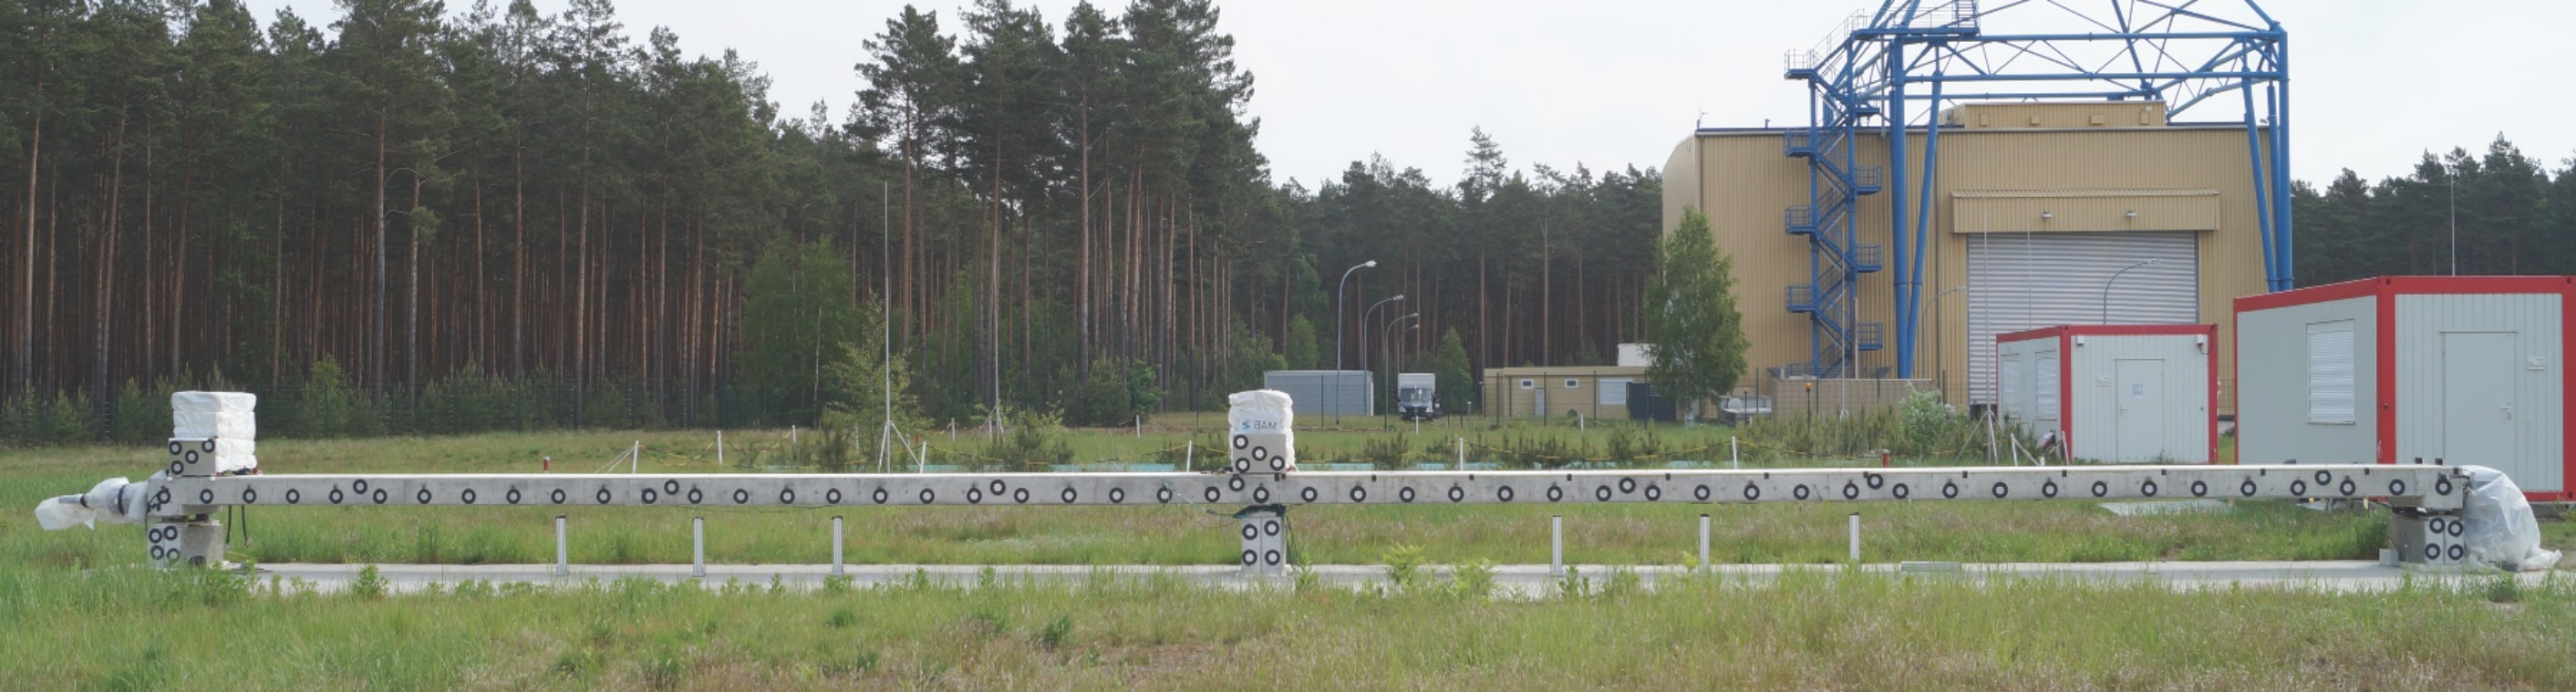

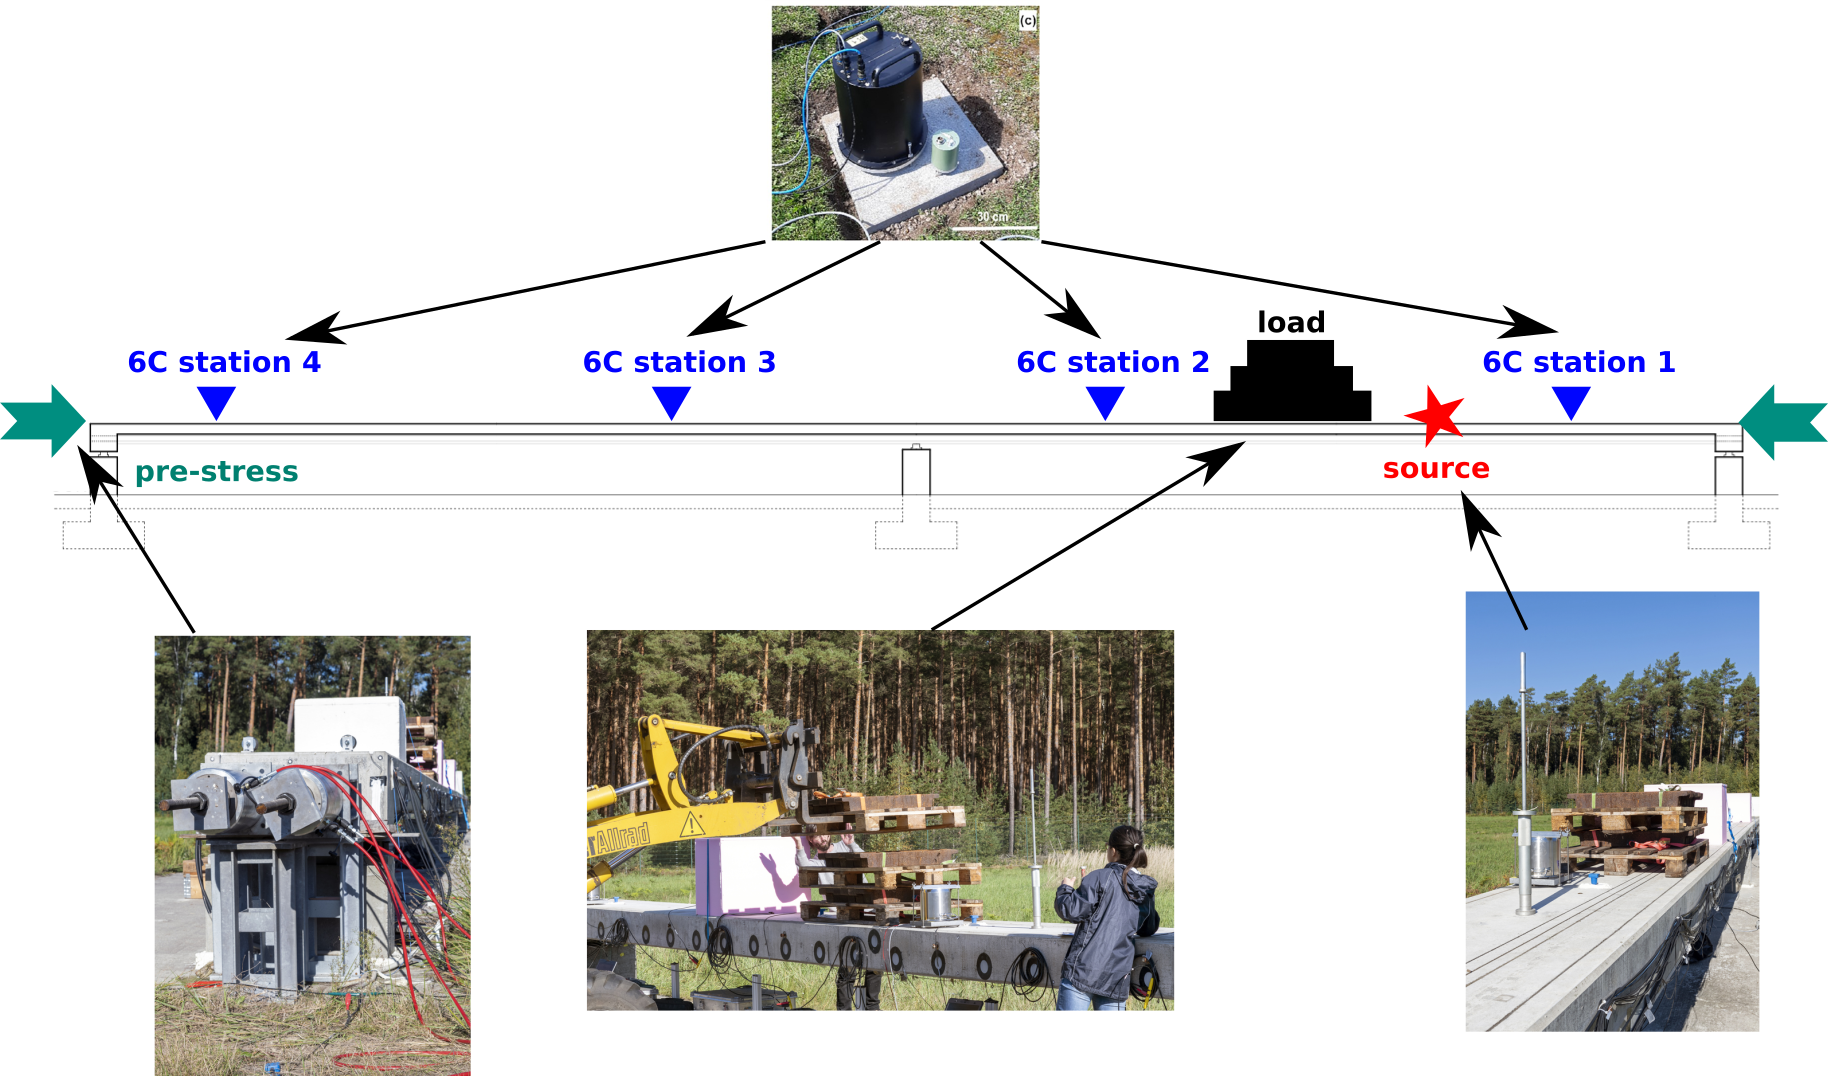

In [ ]:
import numpy as np
import scipy as sp

from obspy import *
import matplotlib.pyplot as plt

from utils_dv_v_6C import plot_bridge_data


In [ ]:
# a function to get and pre-process the data:
# remove the offset, taper, remove the response, filter and resample to 100sps
def get_data(path, sta, cha, starttime, endtime, fmin, fmax):
    mainpath = path+'mseed/'
    yyyy = str(starttime.year)
    DDD = str(starttime.julday).zfill(3)
    fname = 'XX.'+sta+'..'+cha+'.D.'+yyyy+'.'+DDD
# cut out the data
    st = read(mainpath+fname, starttime=starttime-2.5, endtime=endtime+2.5)
# attach the response and ...
    inv = read_inventory(path+'stationXML/XX.'+sta+'.BLEIB.xml')
    st.attach_response(inv)
    
    st.detrend('demean')
    st.taper(0.1)
# ... remove the response for the BB seismometer
    if sta.startswith('BBAM'):
        st.remove_response(water_level=60, output='ACC')
# ... scale the data with the over all sensitivity for the rotation sensor
    if sta.startswith('RBAM'):
        st.remove_sensitivity()
# filter the data in the required frequency range
    st.filter('bandpass', freqmin=fmin, freqmax=fmax, zerophase=True, corners=4)

# resample to 100 Hz
    st.resample(100)

# trim to the required time span
    st.trim(starttime, endtime)
    
    return st


In [ ]:
# a simple function to read and parse our experiment protocol:
def read_events(path_to_file):
    evt_file = open(path_to_file, 'r')
    evt_start = []
    evt_end = []
    ps = []
    load = []
    source = []
    while True:
        evt = evt_file.readline()
        if not evt:
            break
        for i in range(3):
            evt = evt_file.readline().split(' ')
            evt_start.append(UTCDateTime(evt[0]))
            evt_end.append(UTCDateTime(evt[1]))
            ps.append(float(evt[2]))
            load.append(float(evt[3]))
            source.append(evt[4][:-1])

    return evt_start, evt_end, ps, load, source


In [ ]:
# This function calculates the ratio between rotation rate and acceleration as a linear least squares regression.
def vel_from_amps(rr, acc, event_length, thresh, srate, offset, doplot):
    win_len = 1.0 # seconds
    win_nsamp = int(win_len * srate)
    npts = len(rr)
    first = 0
    last = win_nsamp
    start = int(offset)
    stop = int(offset+event_length)
# initialize lists:
    VEL, ccorr = [], []
# we loop over the windows until we reach the end of the trace
    while last < npts:
        r = rr[first:last]
        a = acc[first:last]
        c, p = sp.stats.pearsonr(r, a)
        ccorr.append(c)
        _vel = []
        A = []
        R = []
# we check if the cross-correlation coefficient for this window is larger than 0.9
        if np.abs(c) > 0.9:
            for i in range(len(r)):
# we take only rotation rate values that are above the self-noise
# assuming that acceleration is above self-noise if rotation rate is above self-noise
                if np.abs(r[i]) >= thresh:
                    R.append(r[i])
                    A.append(a[i])
        R = np.asarray(R)
        A = np.asarray(A)
# the linear regression
        _R = np.vstack([R, np.ones(len(R))]).T
        Vel, c = np.linalg.lstsq(_R, A, rcond=None)[0]
        VEL.append(Vel)
# move to the next window
        first = int(first+win_nsamp)
        last = int(first+win_nsamp)
        
    ccorr = np.asarray(ccorr)
# now we cut out the interesting part of the event
    VEL = np.asarray(VEL[start:stop])
    vel = np.nanmedian(VEL)

# We implement the option to plot the analysis step from each single event
    if doplot == True:
        rgba1 = (216/255,27/255,96/255,1)
        rgba3 = (255/255,183/255,7/255,1)

        fig, ax0 = plt.subplots(1, 1, figsize=(6, 5))
        ax1 = ax0.twinx()
        ax0.plot(np.arange(0,len(rr),1)*(1/srate), rr/max(rr), color='r', linewidth=1.5)
        ax0.plot(np.arange(0,len(acc),1)*(1/srate), acc/max(acc), color='k', linewidth=1)
        t_vel = (np.arange(0, len(VEL), 1)) * win_len + start
        t_corr = np.arange(0, len(ccorr), 1) * win_len
        ax1.plot(t_vel, np.abs(VEL), color=rgba1)
        ax0.plot(t_corr, ccorr, color=rgba3)
        ax0.set_xlim(0,len(rr)*(1/srate))
        ax0.set_ylim(-1.1,1.1)
        ax1.set_ylim(0, 120)
        ax0.set_xlabel('time [s]')
        ax0.set_ylabel('norm. amp / ccorr')
        ax1.set_ylabel(r'acc/rr [m/s]', color=rgba1)
        ax0.tick_params(axis='x', which='both', direction='in', top=True, bottom=True)
        ax0.tick_params(axis='y', which='both', direction='in', left=True, labelleft=True)
        ax1.tick_params(axis='y', which='both', direction='in', right=True, labelright=True, left=False, labelleft=False, color=rgba1, labelcolor=rgba1)

        plt.show()
        
    return vel

### Now we can start

In [ ]:
# enter the path pointing to the data contained in the folder "data_dv_v_6C"
path = './data_dv_v_6C/'

let's choose a 6C sensor pair

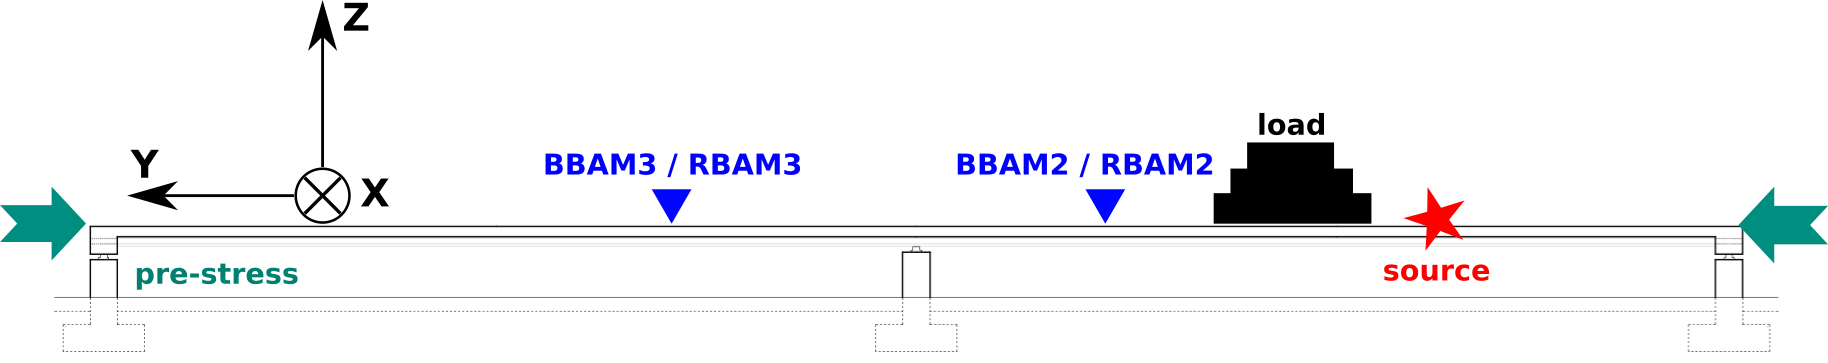

In [ ]:
sta_rr = 'RBAM3'
sta_acc = 'BBAM3'

... and the corresponding components

In [ ]:
cha_rr = 'HJX'
cha_acc = 'HHZ'

Let's concentrate on the first fundamental mode of the bridge.

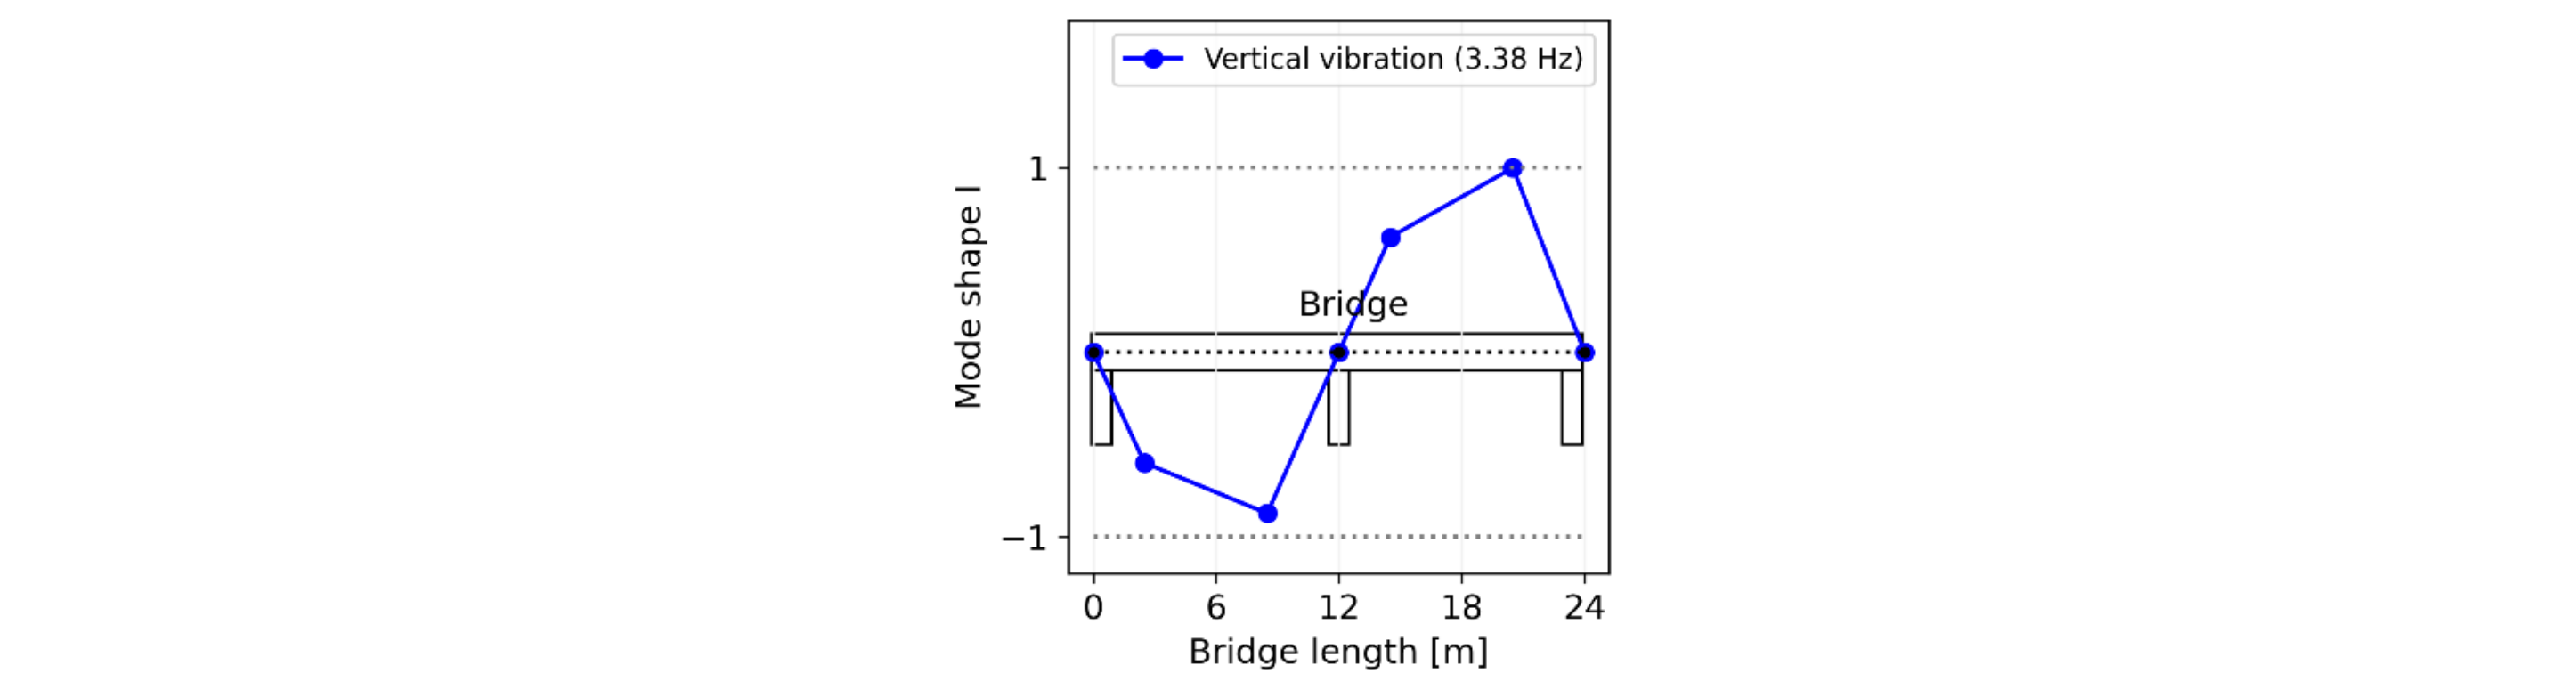

In [ ]:
fmin = 1.0
fmax = 5.0

Now, let's define where we get the start and end times of our events as well as the corresponding pre-stress and load parameters (this is our experiment protocol).

In [ ]:
evt_file = path+'events/events.txt'
start_times, end_times, pre_stress, load, source = read_events(evt_file)

Now we need some working parameters:

In [ ]:
# time span in seconds from the beginning of the trace to the start of the interesting data
offset = 8 # seconds
# time span in seconds to be analysed after the offset
evt_len = 12.0 # seconds
# a threshold to avoid the self-noise of the rotation sensor
thresh = 1e-8 # rad/s

Here you can choose if you want to plot the results from the individual steps:

In [ ]:
doplot = True
#doplot = False

Let's loop over the events:

In [ ]:
# initialize some lists and an event counter
vels = []
Sstart_times = []
_v0 = []
k = 0

for i in range(len(start_times)):
    k+=1
# generate an output to know where we are:
    print('###########################################################################')
    print('number of event: ',k, ', pre-stress: ', pre_stress[i], ', load: ', load[i])
    print('time: ', start_times[i])
    print(' ')
# get rotation rate and translational acceeration data:
    st_rr = get_data(path, sta_rr, cha_rr, start_times[i], end_times[i], fmin, fmax)
    st_acc = get_data(path, sta_acc, cha_acc, start_times[i], end_times[i], fmin, fmax)
    
    rr = st_rr[0].data
    acc = st_acc[0].data

# calculate the velocities as the ratio between acc and rr:
    vel = vel_from_amps(rr, acc, evt_len, thresh, st_rr[0].stats.sampling_rate, offset, doplot)
    vels.append(vel)

# we need to keep the "zero velocity" in mind.
# We choose the "zero velocity" at load = 0kg and pre-stress = 400kN. 
    if load[i] == 0.0 and pre_stress[i] == 400:
        _v0.append(vel)
        
# ... and calculate the relative velocity change with respect to the defined "zero velocity":
vels = np.asarray(vels)
_v0 = np.asarray(_v0)
v0 = np.mean(_v0)
dv_v = ((vels - v0) / v0) * 100

 

In [ ]:
plot_bridge_data(start_times, dv_v, load)

compare this to the results obtained with coda wave interferometry:

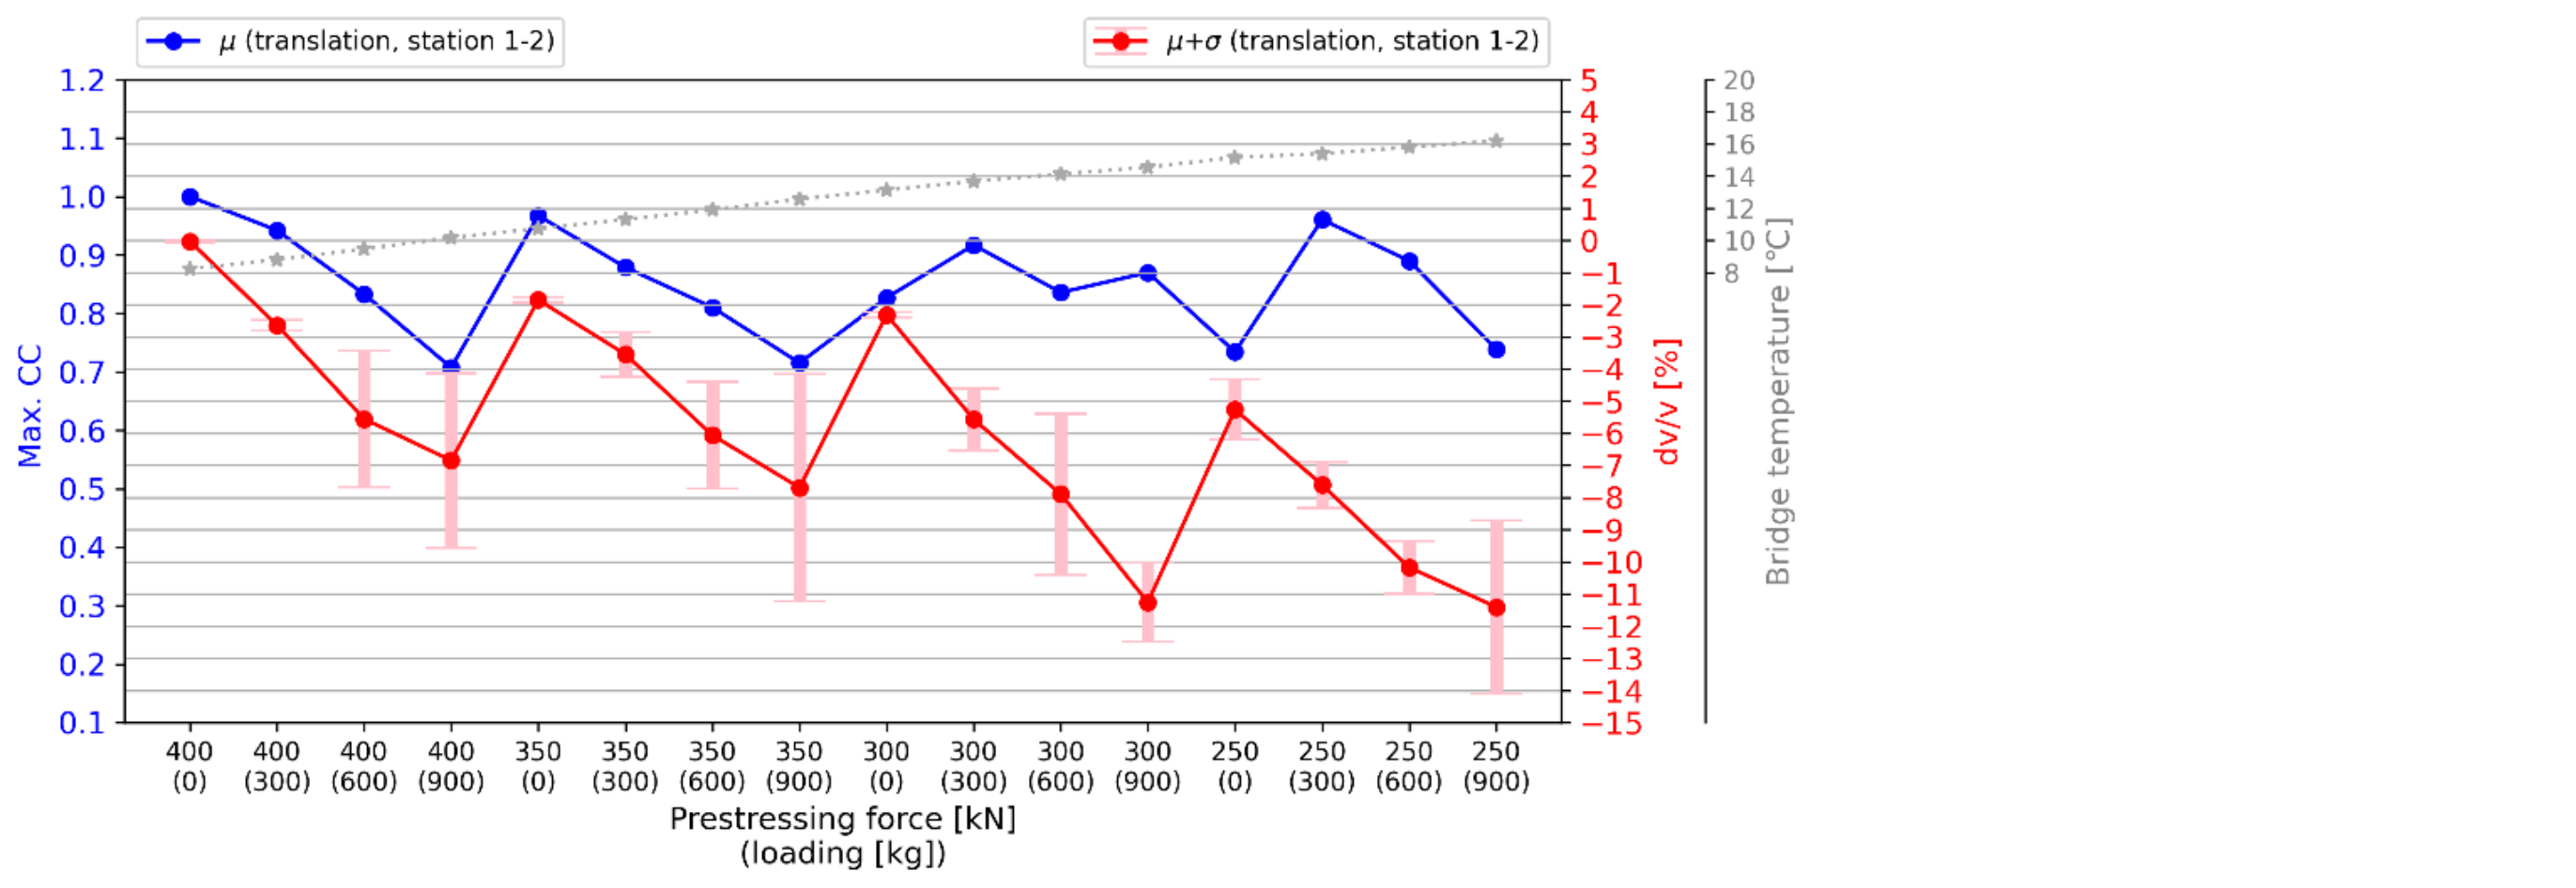